# Google Earth Engine

Google Earth Engine is a cloud computing platform with a **multi-petabyte catalog** of satellite imagery and geospatial datasets. During the past few years, this platform has become very popular in the geospatial community because it enables large-scale remote sensing studies (i.e. continental- to global-scale analysis using medium resolution imagery). 

There are both JavaScript and Python APIs for using Earth Engine. We write code using these APIs on our local machines which is then executed remotely on Google's servers. Therefore we never have to download raw datasets. Instead we return only the results we need from our analysis. 

In this lecture, we will demonstrate how to use **Earth Engine Python API** to track the area of an ice cap in western Greenland between 2015 and 2025. The ice cap is a lobe of the larger **Tasersiap Sermia**. We will use Landsat data which is the longest continuous satellite record of the Earth's land surface. There are a number of different Landsat datasets, related to satellite platform and processing level. We will use the [Landsat 8, Collection 2, Tier 1 Surface Reflectance](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2) product. 

The `geemap` package will make this analysis much easier. `geemap` enables us to **visualize** Earth Engine datasets interactively within a Jupyter environment with minimal coding. As we will see in this demo, this will be very important for debugging our code. 

```{note}
Students will need to register for an Earth Engine account before executing the code in this notebook.
```

## Install Earth Engine

It is recommended to use `conda` to install `geemap` and its dependencies. It is a good practice to install this package to a new environment to reduce risk of version conflicts with other geospatial packages. 

```bash
conda create -n gee python
conda activate gee
conda install -c conda-forge geemap
```

```{note}
Installing `geemap` will automatically install all of its dependencies, including the `earthengine-api` package.
```

In [1]:
# Import packages
import ee
import geemap
import time
import numpy as np

## Authenticate and initialize

We will need to authenticate Earth Engine before using it. After running the following code cell, a pop-up window will appear and we will be asked to authorize the **Google Earth Engine Authenticator**. 

The first time we run this cell, we will also have to select a **Cloud Project** to use for Earth Engine. Once we have confirmed the Cloud Project, we will be provided with a verification code which we can paste into the box that will appear below the cell.

Authentication for local installations should be a one-time thing since it generates a persistent authorization token that is stored locally in the `.config` folder on our computer. But we will have to run `Initialize` for each new Python session. 

In [2]:
# Authenticate
ee.Authenticate()  

# Change default project name
ee.Initialize(project='ee-icecap')

## Interactive map

`geemap` provides functionality for visualizing data in Earth Engine interactively. To demonstrate, we will define a square region over an area of western Greenland to plot the Tasersiap Sermia lobe. 

In [3]:
latitude = 66.128
longitude = -50.306
size = 21000

We can now convert this float values to an Earth Engine `geometry` data type which is the format in which GEE stores geospatial shapes. In the first line, we define a single point, and then we `buffer` the point to a square of the the size we want.

In [4]:
point = ee.Geometry.Point(longitude, latitude)
region = point.buffer(size/2).bounds()
type(region)

ee.geometry.Geometry

If we plot that `region`, we will see that we are looking in the right place.

```{note}
Installing `geemap` will automatically install all of its dependencies, including the `earthengine-api` package.
```

In [5]:
Map = geemap.Map()                # Make empty map
Map.addLayer(region)              # Add region layer
Map.centerObject(region, zoom=10) # Center on region
Map                               # Display

Map(center=[66.12795867729072, -50.3055343249625], controls=(WidgetControl(options=['position', 'transparent_b…

## Plot data

We're ready to plot some data. To start with, we will visualize a single Landsat image. To narrow our search, we will define a time period by setting a start and an end date.

In [6]:
date_start = '2023-07-01'
date_end = '2023-08-31'

**Collection 2** is the "version 2" of the standard reprocessing of the Landsat archive. **Tier 1** is the highest-quality data, and **Surface Reflectance** means that the data has been corrected to remove the effects of the atmosphere. The reflectance values from multiple scenes acquired during different times of the day, in different lighting conditions therefore *should* be comparable.

```{image} images/landsat.png
:width: 1000px
:align: center
```

We can acquire all Landsat products within our specified spatial and temporal bounds using `ImageCollection` function.

In [7]:
# Get Landsat 8 image collection
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")

# Filter to desired region and date bounds
image_collection = image_collection.filterBounds(region)
image_collection = image_collection.filterDate(date_start, date_end)

type(image_collection)

ee.imagecollection.ImageCollection

An `ImageCollection` contains a list of `features` (images) and `bands` (e.g. red, blue, NIR) that the images have in common. Each `Image` contains its own `bands` which contain actual data as well as `properties` which contains metadata associated with each image such as image acquisition times, cloud cover, correction coefficients.

In [8]:
image_collection

Usually the **best** image will be the one with the least cloud cover. We can find the image with the least cloud cover by sorting the collection from least to most cloudy and selecting the first image. We will also clip this image to our search region, so we can focus on our study area. 

In [9]:
image = image_collection.sort('CLOUD_COVER').first()
image = image.clip(region)

Now we're ready to visualize this image. We use the `Map` function and include parameters to view a **true color** image (i.e. bands 4, 3, and 2 which are red, green, and blue).

In [10]:
Map = geemap.Map()
visParams = {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
Map.addLayer(image, visParams)
Map.centerObject(region, zoom=11)
Map

Map(center=[66.12795867729072, -50.3055343249625], controls=(WidgetControl(options=['position', 'transparent_b…

In [11]:
# Define name of folder and file
folder = 'ee-icecap'
region_name = 'Tasersiap-Sermia'

# Get the data of the image from the metadata
date_string = image.get('DATE_ACQUIRED').getInfo()

# Define filename
filename = region_name + '_' + date_string

# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': image.select(['SR_B4', 'SR_B3', 'SR_B2']),
    'description': filename,
    'folder': folder,
    'scale': 30,
    'region': region.getInfo()['coordinates']
})
task.start()

print(f'Exporting {filename}.tif to Google Drive...')

Exporting Tasersiap-Sermia_2023-08-08.tif to Google Drive...


## Image analysis

Often in remote sensing analysis, we use normalized difference indices to emphasize a specific land cover type. The **Normalized Difference Snow Index (NDSI)** can be used to distinguish snow from other surfaces like clouds, vegetation, and soil. We compute the NDSI using the Green and SWIR bands which correspond to Band 3 and Band 6 following this [document](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_TOA#bands).

$$
\text{NDSI} = \frac{(G - SWIR)}{(G + SWIR)}
$$

In [12]:
image.bandNames().getInfo()

['SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'SR_QA_AEROSOL',
 'ST_B10',
 'ST_ATRAN',
 'ST_CDIST',
 'ST_DRAD',
 'ST_EMIS',
 'ST_EMSD',
 'ST_QA',
 'ST_TRAD',
 'ST_URAD',
 'QA_PIXEL',
 'QA_RADSAT']

In [13]:
r_high = 'SR_B3'  # relevant band name for r_high
r_low = 'SR_B6'   # relevant band name for r_low

ndsi = image.normalizedDifference([r_high, r_low]).rename('NDSI')

ndsi

In [14]:
Map = geemap.Map()

# Display colour image
visParams = {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
Map.addLayer(image, visParams, 'True Colour')

# Display NDSI
visParams = {'bands': ['NDSI'], 'min': -1, 'max': 1, 'palette': ['red', 'white', 'blue']}
Map.addLayer(ndsi, visParams)

# Add colorbar for NDSI
Map.add_colorbar(
    vis_params=visParams,
    label="NDSI Index",
    orientation='horizontal',
    position='bottomright'
)

Map.centerObject(region, zoom=11)
Map

Map(center=[66.12795867728894, -50.30553432496249], controls=(WidgetControl(options=['position', 'transparent_…

## Threshold image

To compute the area of the ice cap, we need to produce a **binary mask** that determines whether pixels belong to the ice cap or not. We can do this using a thresholding approach. While this technique is conceptually simple, it is often challenging to identify an optimal threshold.

A good way to begin identifying a threshold is to produce a **histogram** of NDSI values in the scene. Below we will sample 10,000 pixels within the scene

In [15]:
import geemap.chart as chart

# Sample 10,000 pixels within the NDSI image
sample_pixels = ndsi.sample(region, numPixels=10000)

# Set labels for the graph
labels = {"title": 'Distribution of NDSI values within image'}

# Construct the histogram
chart.feature_histogram(sample_pixels, 'NDSI', **labels)

The histogram shows that the data has a **bimodal distribution**, with lots of land surface with NDSI values < 0 and the ice cap with NDSI values >0.6. There is also a large spike, presumably related to the river. 

```{note}
The `gt` function denotes **greater than**. `lt` would be **less than**.
```

In [16]:
# Manually set a threshold
threshold = 0.2

# Threshold the image (ice cap is values greater than threshold)
ndsi_threshold = ndsi.gt(threshold)

# Mask data, showing only regions beyond the threshold.
ndsi_threshold = ndsi_threshold.updateMask(ndsi_threshold.neq(0))

We can visualize our classification by making it semi-transparent and overlaying it over our original true color image. Note that we also set values that are lower than the threshold to 0 so that they are fully-transparent.

In [17]:
Map = geemap.Map()

# Display colour image
max_reflectance = 0.8
visParams = {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
Map.addLayer(image, visParams, 'True Colour')

# Display NDSI
visParams = {'bands': 'NDSI', 'palette': ['white', 'cyan'], 'opacity': 0.3}
Map.addLayer(ndsi_threshold, visParams, 'NDSI')

Map.centerObject(region, zoom=11)
Map

Map(center=[66.12795867729072, -50.3055343249625], controls=(WidgetControl(options=['position', 'transparent_b…

## Import shapefile

This is a good start but it would be challenging to quantify the area of the ice cap because there are other features in the bounding box that have high NDSI values such as the river and several snow patches adjacent to the ice cap. To remove these features from our analysis, we can import a polygon which delineates the outer edge of the ice cap. 

The [Randolph Glacier Inventory (RGI)](https://www.glims.org/rgi_user_guide/01_introduction.html) is a dataset that contains outlines of every glacier on Earth (excluding the ice sheets in Greenland and Antarctica) for the target year 2000.

```{image} images/rgi-logo.png
:width: 200px
:align: center
```

```{image} images/rgi-glacier.png
:width: 700px
:align: center
```

We downloaded the RGI v7.0 and identified the outline of our ice cap. To use this file in Earth Engine, we have to import it as an **Asset**. We can can do this going to [https://code.earthengine.google.com/](https://code.earthengine.google.com/), selecting **Assets** from the top-left sidebar, and clicking **New** --> **Shape files** under the Table Upload section. This will open a pop-up that will allow us to select the relevant files. 

```{note}
Note that the `.shp`, .`dbf`, and `.shx` files are required. If the `.prj` file is not provided, WGS84 is assumed.
```

Give the table an appropriate **Asset ID** and click **Upload**.


```{image} images/import.png
:width: 700px
:align: center
```

In [18]:
# Import shapefile asset
outline = ee.FeatureCollection("projects/ee-icecap/assets/icecap")
outline

In [19]:
# Add to map
Map = geemap.Map()
visParams = {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
Map.addLayer(image, visParams, 'True Colour')
Map.addLayer(outline, {'color': 'red'})
Map.centerObject(outline, 11)
Map

Map(center=[66.13242371703917, -50.32080203361965], controls=(WidgetControl(options=['position', 'transparent_…

## Intersect raster with polygon

We can now refine our analysis by only counting pixels within the outline of the ice cap. 

In [20]:
# Define size of Landsat pixel
scale = 30
pixel_area_m2 = scale * scale

start = time.time()

pixel_count = ndsi_threshold.reduceRegion(reducer=ee.Reducer.count(), geometry=outline,
    scale=scale, maxPixels=1e9)

end = time.time()
print(f"Execution time: {end - start:.4f} seconds")

Execution time: 0.0003 seconds


In [21]:
start = time.time()

# Extract and print the result
number = pixel_count.getInfo()

# Convert to km2
total_area_km2 = number['NDSI'] * pixel_area_m2 / 1000000
print(f'Total area of ice cap: {total_area_km2} km2')

end = time.time()
print(f"Execution time: {end - start:.4f} seconds")

Total area of ice cap: 181.7676 km2
Execution time: 0.3662 seconds


We might be wondering why the first task (i.e. counting all the pixels within the polygon) was executed almost instantly. But the second task (i.e. simply returning the `pixel_count` value using `getInfo`) took orders of magnitude longer. This is because Earth Engine uses a **lazy evaluation model** (also known as deferred execution). 

When we write Python code using Earth Engine functions, we are not performing immediate computations on our local machines. Instead, we are building a **computation graph** which is a set of instructions that describe the operations we want to perform on data stored on Google's servers. 

The execution of the code only occurs when we use specific methods that require the server to respond to our local Python environment. Common trigger methods include:

* `getInfo()`: Returns the result to the client

* `export()`: Returns a file to Google Drive or Cloud Storage

* `addLayer()`: Returns data tiles for visualization

```{important}
The general advice with Earth Engine is to use trigger methods as few times as possible. If we do use the, we should be precise with what we want to return.
```

## Scaling up

If we wanted to track the area of the ice cap through time, we might be tempted to iterate over every image in our `ImageCollection`using a **for loop**. Don't do that! It would involve calling `.getInfo` for each image add would be very slow.

Instead, we should define a function, and apply it to every image in the collection **remotely** using the `map()` function.

Here's an example of generate an `ImageCollection` containing the least cloudy image between Jul 1 and Aug 31 for each year between 2015 and 2025. 

In [22]:
# Define the years of interest
start_year = 2015
end_year = 2025
years = ee.List.sequence(start_year, end_year)

def get_least_cloudy_annual_image(year):

    # Convert year number to date objects for filtering
    start = ee.Date.fromYMD(year, 7, 31)
    end = ee.Date.fromYMD(year, 8, 31)

    # Load the Landsat 8 Collection 2 Tier 1 TOA image collection
    collection = (
        ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
        .filterBounds(region)
        .filterDate(start, end)
        .sort('CLOUD_COVER')
    )

    # Get the first image from the sorted collection
    least_cloudy = ee.Image(collection.first())
    
    return least_cloudy

# Map the function over the list of years to produce ImageCollection
image_collection = ee.ImageCollection(years.map(get_least_cloudy_annual_image))
image_collection

In [23]:
# Define a function to perform the NDSI calculation and pixel counting
def calculate_glacier_area(image):
    
    # Clip the image to the specified region
    image = image.clip(outline)
    
    # Calculate NDSI
    ndsi = image.normalizedDifference([r_high, r_low]).rename('NDSI')

    # Threshold the image
    ndsi_threshold = ndsi.gt(threshold)

    # Mask data
    ndsi_threshold = ndsi_threshold.updateMask(ndsi_threshold.neq(0))

    # Count pixels
    pixel_count = ndsi_threshold.reduceRegion(
        reducer=ee.Reducer.count(), 
        geometry=outline,
        scale=scale, 
        maxPixels=1e9 # Allow for large calculations
    )
    
    # Add the pixel count as a property to the image metadata
    return image.set('ndsi_pixel_count', pixel_count.get('NDSI'))

# Apply the calculation function to every image in the collection
collection_with_counts = image_collection.map(calculate_glacier_area)

In [24]:
# Return values
start = time.time()
pixel_counts = collection_with_counts.aggregate_array('ndsi_pixel_count')
areas = pixel_counts.getInfo()
end = time.time()
print(f"Execution time: {end - start:.4f} seconds")

Execution time: 1.2532 seconds


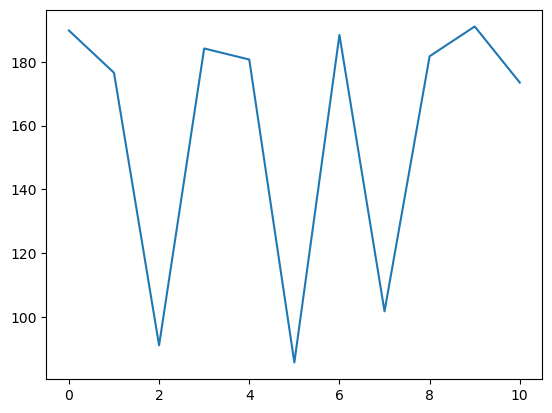

In [25]:
# Calculate total area and plot
total_area_km2 = np.array(areas) * pixel_area_m2 / 1000000.0
import matplotlib.pyplot as plt
plt.plot(total_area_km2)

This is not necessarily the result we were looking for. The rapid changes in ice cap area (from >190 to <100 km2) is not physically possible. There could be several possible reasons for this.

My first suspicion was that even though we picked a relatively large temporal period (Jul 1 to Aug 31), the *least cloudy image* may still contain a lot of clouds. To investigate, we can plot the cloud cover for each image.

In [27]:
# Define cloud cover
cloud_cover_list = image_collection.aggregate_array('CLOUD_COVER')
cloud_cover = cloud_cover_list.getInfo()

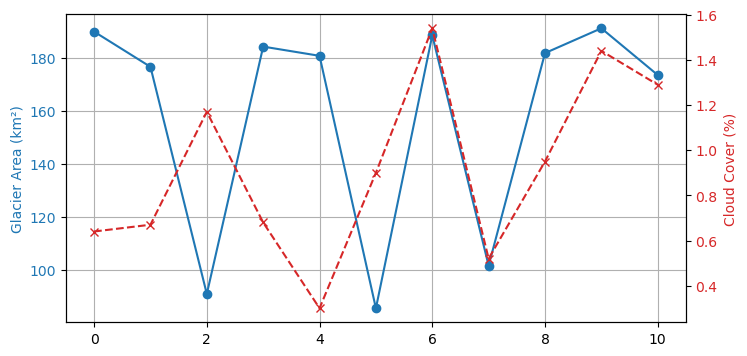

In [28]:
fig, ax1 = plt.subplots(figsize=(8, 4))

color1 = 'tab:blue'
ax1.set_ylabel('Glacier Area (km²)', color=color1)
ax1.plot(total_area_km2, color=color1, marker='o', label='Glacier Area')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()  
color2 = 'tab:red'
ax2.set_ylabel('Cloud Cover (%)', color=color2)  
ax2.plot(cloud_cover, color=color2, marker='x', linestyle='--', label='Cloud Cover')
ax2.tick_params(axis='y', labelcolor=color2)

It looks like cloud cover was pretty low for all our images, certainly not enough to change the ice cap area by tens of kilometers squared.

Let's visualize the `ImageCollection` to see what is going on. Fortunately, `geemap` provides several functions for displaying image collections.  

In [29]:
Map = geemap.Map(center=[40, -100], zoom=4)
vis_params = {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
years = image_collection.aggregate_array('system:index').getInfo()

Map.ts_inspector(
    left_ts=image_collection,
    right_ts=image_collection,
    left_names=years,
    right_names=years,
    left_vis=vis_params,
    right_vis=vis_params,
    width='80px',
)
Map.centerObject(region, zoom=11)
Map

Map(center=[66.12795867729072, -50.3055343249625], controls=(WidgetControl(options=['position', 'transparent_b…

The time-series inspector function provides a slider for visualizing two images side-by-side. We find that some images do not have full coverage of the ice cap. 

In [30]:
Map = geemap.Map()
vis_params = {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
Map.add_time_slider(image_collection, vis_params, time_interval=1)
Map.centerObject(region, zoom=11)
Map

Map(center=[66.12795867729072, -50.3055343249625], controls=(WidgetControl(options=['position', 'transparent_b…

The time slider makes a **video** of our `ImageCollection` that shows that there is tremendous variation in the reflectance of the ice cap from year to year. In some years, the ice cap is fully snow-covered in late-summer. In other years, the snow has melted to reveal glacier across most of the ice cap. Given the variations in reflectance, a simple thresholding approach to classify the ice cap may therefore not be sufficient. 

## Summary

In this lecture, we learnt how to use Google Earth Engine for analyzing area changes of an ice cap in western Greenland. There are several important lessons to takeaway. 

1. Earth Engine requires slightly **different programming techniques** because processing is not performed locally. To get the most out of Earth Engine, we should write code that is executed relatively infrequently. Since we do not often execute code, it can be more challenging to debug.

2. A good strategy for using Earth Engine is to **work backwards**. If we can specifically define the information that we need (e.g. area of ice cap), then we can reduce the number (and size) of requests that we make to Earth Engine servers which will rapidly speed up our code.

3. One way to ensure that our analysis is performing as it should is to have **"eyes on the data"**. `geemap` provides many functions to quickly do this.

4. Our time period (2015-2025) was **too short to detect changes in ice cap area**, which are likely going to be small, even under climate change.

5. We may find larger changes if we used Landsat data from 1980s and 1990s. But this would require using a different classification approach because Landsat 5 has a different sensor to Landsat 8. However, training deep learning models is supported in Earth Engine's APIs. Instead, we have to train a model outside of Earth Engine, and then import it to make predictions. 

## Further reading

[Area, volume and ELA changes of West Greenland local glaciers and ice caps from 1985–2020](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/34D4383F46AB4457B981E519D0194327/S0022143024000765a.pdf/area-volume-and-ela-changes-of-west-greenland-local-glaciers-and-ice-caps-from-1985-2020.pdf)

[Earth Engine and Geemap - Geospatial Data Science with Python](https://book.geemap.org/index.html)

[GEOG2462 Project 2A: Remote Sensing of Surface Change](https://github.com/trchudley/GEOG2462/tree/main)